# Dynamic simulations of enzyme cycles using generalised rate laws
BondGraphTools provides tools for modelling biochemical networks. The package contains a library with storage and dissipative components that enable the specification of models under the mass action framework. While support for rate laws corresponding to enzyme-catalysed reactions is not supported by default, the package provides an interface for defining components with new constitutive equations. In this notebook we define a constitutive relationship corresponding to Michaelis-Menten kinetics and use this to simulate dynamic networks of enzymes described by these rate laws. First we import the necessary packages.

In [1]:
import BondGraphTools as bgt
from matplotlib import pyplot as plt
import sympy as sp

sp.init_printing()

## Defining the Michaelis-Menten rate law
In this section we show how an enzyme catalysed reaction $S \rightleftharpoons P$ can be described using Michaelis-Menten kinetics. The **C** components corresponding to the species can be defined as follows:

In [2]:
C_S = bgt.new(component="Ce",name="S",library="BioChem")
C_P = bgt.new(component="Ce",name="P",library="BioChem")

Note that in the above block of code, the `Ce` components are defined within the `BioChem` library. Therefore, it is possible to define our own libaries with arbitrary components. We show an example of this in the code below, which defines a component corresponding to Michaelis-Menten enzyme kinetics:

In [3]:
with open("enzymes.json") as f:
    print(f.read())

{
    "description": "Enzyme catalysed reactions",
    "id":"Enzyme",
    "components":{
      "R_MM":{
        "description": "Michaelis-Menten reaction",
        "class": "Component",
        "metamodel":"R",
        "ports":{
          "0":{"description":"Substrate"},
          "1":{"description":"Product"}
        },
        "params":{
          "r1":{"description":"Rate of reaction 1"},
          "r2":{"description":"Rate of reaction 2"},
          "k_c":{"description":"Affinity of complex relative to free enzyme"},
          "e_T":{"description":"Total amount of enzyme"},
          "R":{"description":"Universal Gas Constant"},
          "T":{"description": "Temperature"}
        },
        "constitutive_relations":[
          "f_0 + f_1",
          "f_0 - e_T*r1*r2*k_c*(exp(e_0/R/T) - exp(e_1/R/T)) / (r1*exp(e_0/R/T) + r2*exp(e_1/R/T) + k_c*(r1+r2))"
        ]
      }
    }
  }


In terms of the chemical potentials $\mu_S$ and $\mu_P$ of the substrate and product, the rate law has been defined as

$$
v(\mu_S,\mu_P) = e_T \frac{r_1 r_2 k_C (e^{\mu_S/RT} - e^{\mu_P/RT})}{r_1 e^{\mu_S/RT}+r_2e^{\mu_P/RT} + k_C(r_1 + r_2)}
$$

where $e_T$ (total amount of enzyme), $r_1$ (normalised rate of the first reaction), $r_2$ (normalised rate of the second reaction) and $k_C$ (affinity of the complex relative to the free enzyme) are the parameters of the equation.

Therefore if the substrate corresponds to the 0 port and the product corresponds to the 1 port the constitutive equations of the model are

$$
\begin{align}
f_0 + f_1 &= 0 \\
f_0 - v(e_0,e_1) &= 0
\end{align}
$$

The library can be loaded into BondGraphTools using the code below:

In [4]:
bgt.component_manager.load_library('enzymes.json')

True

Now a new dissapative component with Michaelis-Menten kinetics can be created:

In [5]:
R_MM = bgt.new(component="R_MM",name="E",library="Enzyme")

The constitutive equations for this components are as expected:

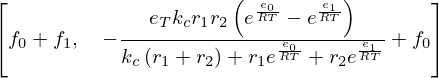

In [6]:
R_MM.constitutive_relations

We now make a new model of the network $S \rightleftharpoons P$. The bond graph of the model is drawn below.

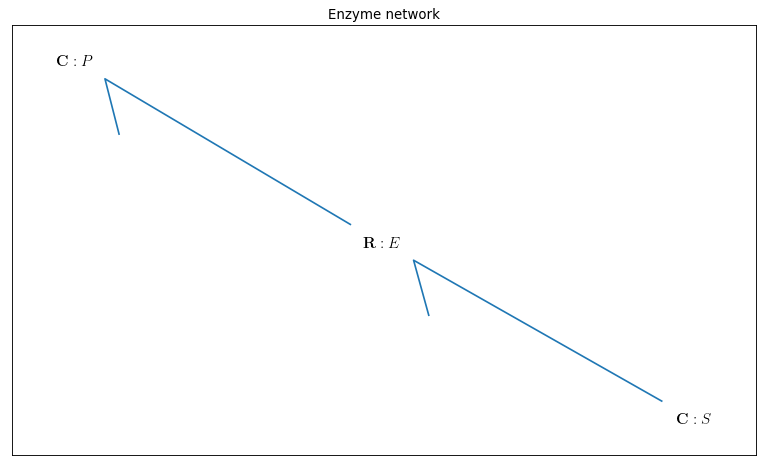

In [7]:
model = bgt.new(name="Enzyme network")
bgt.add(model,C_S,C_P,R_MM)
bgt.connect(C_S,(R_MM,0))
bgt.connect((R_MM,1),C_P)

C_S.set_param("k",1)
C_S.set_param("R",1)
C_S.set_param("T",1)

C_P.set_param("k",1)
C_P.set_param("R",1)
C_P.set_param("T",1)

R_MM.set_param("r1",200)
R_MM.set_param("r2",200)
R_MM.set_param("k_c",1)
R_MM.set_param("e_T",1)
R_MM.set_param("R",1)
R_MM.set_param("T",1)

bgt.draw(model)

The constitutive equations of the model are below. Note that it is specified in a differential algebraic equation (DAE) form. It appears that the symbolic manipulation has not fully simplified the equations. However, we will develop a workaround for this in the next section.

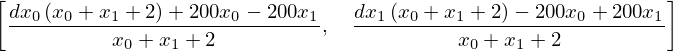

In [8]:
model.constitutive_relations

Despite the equations being specified as DAEs, they can still be simulated by the package.

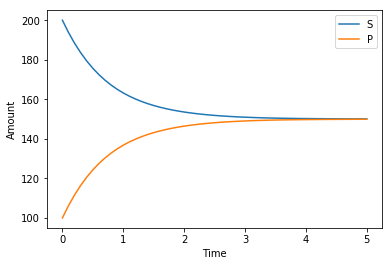

In [9]:
t,x = bgt.simulate(model,timespan=(0.,5.), x0=[200,100])
plt.plot(t,x)
plt.xlabel("Time")
plt.ylabel("Amount")
plt.legend(["S","P"])

Below we create a model with the full mass action equations, then simulate it.

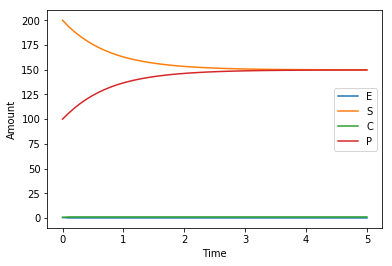

In [10]:
from BondGraphTools import reaction_builder

def mass_action_model():
    reactions = [
        ("E + S = C","R1"),
        ("C = E + P","R2")
    ]
    
    rn = reaction_builder.Reaction_Network()
    for r in reactions:
        rn.add_reaction(r[0],name=r[1])
    
    model = rn.as_network_model()
    
    for s in rn.species:
        (model/f"C:{s}").set_param("k",1)
        
    for r in rn._reactions.keys():
        (model/f"R:{r}").set_param("r",200)
    
    return model

def species_order(model):
    return [v[0].name for v in model.state_vars.values()]
def biochemical_ic(model,ic):
    return [ic[s] for s in species_order(model)]

ma_model = mass_action_model()
initial_conditions = {"E":0.5,"C":0.5,"S":200,"P":100}
     
t_ma,x_ma = bgt.simulate(ma_model,
                         timespan=(0.,5.), 
                         x0=biochemical_ic(ma_model,initial_conditions))
plt.plot(t_ma,x_ma)
plt.xlabel("Time")
plt.ylabel("Amount")
plt.legend(species_order(ma_model))

To verify that the Michaelis-Menten approximation is appropriate in this case, we compare the simulation results between the two models. As expected, the results from the two simulations are similar, owing to the relatively small amount of enzyme relative to metabolites.

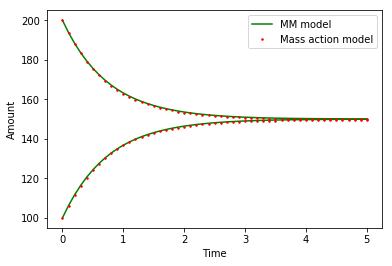

In [11]:
fig = plt.figure()

l1,l2 = plt.plot(t,x,'g')

idx_metabolites = [species_order(ma_model).index(s) for s in ["S","P"]]
l3, l4 = plt.plot(t_ma,x_ma[:,idx_metabolites],'ro',markersize=1.5)

plt.xlabel("Time")
plt.ylabel("Amount")
plt.legend((l1,l3),("MM model","Mass action model"))

## Simplifying network constitutive equations
As noted in the previous section, the equations for the Michaelis-Menten model were not fully simplified. While this did not cause any issues during simulation (BondGraphTools uses a DAE solver to simulate all models), it may be useful to remove redundant terms for ease of interpretability and computational efficiency. Below we show one possible workaround that enables this simplification.

We define a new class (`ODEModel`) that inherits the standard bond graph functions, but with a modification to how constitutive equations are derived. Note that this new class does not check for correctness, and will likely produce incorrect results for models that are not ODEs.

In [12]:
from BondGraphTools import BondGraph

class ODEModel(BondGraph):
    def __init__(self, name, components=None, **kwargs):
        super().__init__(name,components,**kwargs)
        
    @property
    def constitutive_relations(self):
        equations = super().constitutive_relations
        dx = [rate_symbol(expr) for expr in equations]
        ode_constraints = [r-sp.solve(expr,r)[0] for expr,r in zip(equations,dx)]
        
        return ode_constraints
    
def rate_symbol(x):
    return next(filter(lambda s: str(s)[0:3] == 'dx_',x.free_symbols))

The Michaelis-Menten model in the previous section can then be defined using this new class in exactly the same manner, but initialised using the `ODEModel` class.

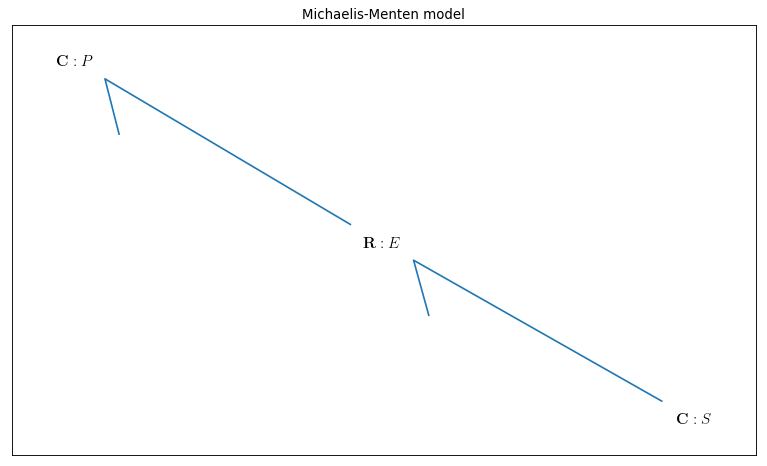

In [13]:
species_params = params={'k':1,'R':1,'T':1}
reaction_params = params={'r1':200,'r2':200,'k_c':1,'e_T':1,'R':1,'T':1}

ode_model = ODEModel(name="Michaelis-Menten model")
bgt.add(ode_model,
    bgt.new(component="Ce",name="S",library="BioChem",value=species_params),
    bgt.new(component="Ce",name="P",library="BioChem",value=species_params),
    bgt.new(component="R_MM",name="E",library="Enzyme",value=reaction_params)
)
bgt.connect(ode_model/"C:S",(ode_model/"R:E" , 0))
bgt.connect((ode_model/"R:E" , 1),ode_model/"C:P")
bgt.draw(ode_model)

The constitutive equations for this model are now simplified so that the common positive denominator has been removed.

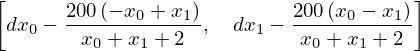

In [14]:
ode_model.constitutive_relations

Simulation of this model gives rise to the same results.

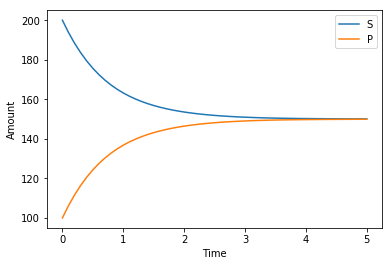

In [15]:
t,x = bgt.simulate(model,timespan=(0.,5.), x0=[200,100])
plt.plot(t,x)
plt.xlabel("Time")
plt.ylabel("Amount")
plt.legend(["S","P"])

## Coupled enzyme-catalysed reactions
Because the Michaelis-Menten rate law has been defined in a bond graph components, it is now possible to use this describe biochemical pathways. Below we define a relatively simple example for the network $A \rightleftharpoons B \rightleftharpoons C$.

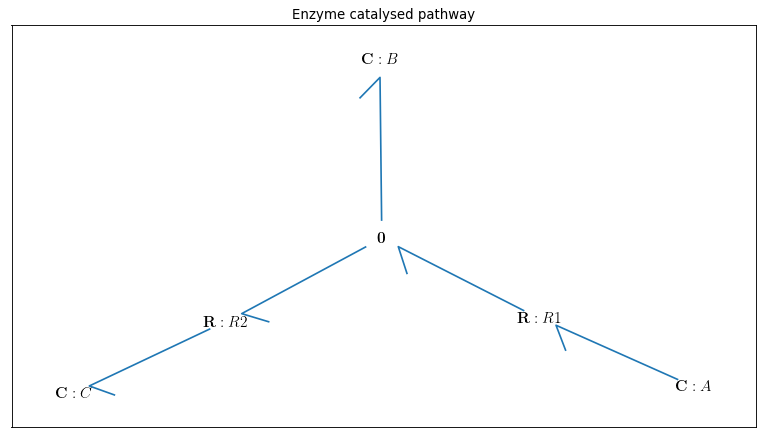

In [16]:
def pathway():
    species_params = {'k':1,'R':1,'T':1}
    reaction_params ={'r1':100,'r2':100,'k_c':1,'e_T':1,'R':1,'T':1}
    
    C_A = bgt.new(component="Ce",name="A",library="BioChem",value=species_params)
    C_B = bgt.new(component="Ce",name="B",library="BioChem",value=species_params)
    C_C = bgt.new(component="Ce",name="C",library="BioChem",value=species_params)
    
    R1 = bgt.new(component="R_MM",name="R1",library="Enzyme",value=reaction_params)
    R2 = bgt.new(component="R_MM",name="R2",library="Enzyme",value=reaction_params)
    
    effort_B = bgt.new("0")
    
    model = ODEModel(name="Enzyme catalysed pathway")
    
    bgt.add(model,C_A,C_B,C_C,R1,R2,effort_B)
    
    bgt.connect(effort_B,C_B)
    bgt.connect(C_A,(R1,0))
    bgt.connect((R1,1),effort_B)
    bgt.connect(effort_B,(R2,0))
    bgt.connect((R2,1),C_C)
    
    return model
    
m = pathway()
bgt.draw(m)

The constitutive equations for the model are below

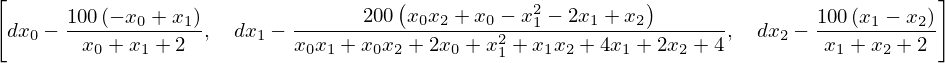

In [17]:
m.constitutive_relations

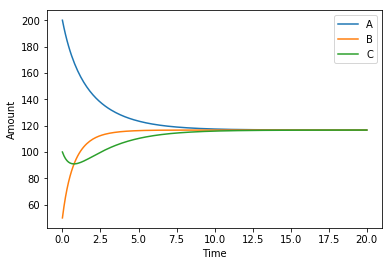

In [18]:
t,x = bgt.simulate(m,timespan=(0.,20.),x0=[200,50,100])
plt.plot(t,x)
plt.xlabel("Time")
plt.ylabel("Amount")
plt.legend(["A","B","C"])